# Curvature
This example performs curvature optimization

In [1]:
from quadcoil import quadcoil
from quadcoil.quantity import Phi_with_net_current

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import time

In [3]:
from simsopt import load

## Loading data

In [4]:
# The example is li383.
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
import jax
jax.config.update('jax_enable_x64', True)

## Running topology-constrained as comparison

In [5]:
if net_poloidal_current_amperes > 0:
    K_theta_sign = '>='
else:
    K_theta_sign = '<='
print('K_theta constraint sign: ' + K_theta_sign)

K_theta constraint sign: >=


In [6]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
out_dict1, qp1, dofs1, status1 = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=10,
    ntor=10,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=('>=',),
    constraint_value=np.array([0.,]),
    constraint_unit=(None,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K', 'f_max_K_dot_grad_K_cyl'),
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


In [7]:
f_B_ref = out_dict1['f_B']['value']
f_K_ref = out_dict1['f_K']['value']

In [8]:
print('f_B of NESCOIL:', f_B_ref)
print('f_K of NESCOIL:', f_K_ref)
print('Max K dot grad K (cylindrical) of NESCOIL:',  out_dict1['f_max_K_dot_grad_K_cyl']['value'])

f_B of NESCOIL: 0.016553154143183105
f_K of NESCOIL: 132953732549240.58
Max K dot grad K (cylindrical) of NESCOIL: 307015549896998.5


In [9]:
# We run a REGCOIL case, using 2x NESCOIL f_B as 
# Target f_B. Note that because QUADCOIL does constrained 
# optimization, we can run REGCOIL with a desired 
# f_B instead of doing a whole sweep.
regcoil_out_dict, regcoil_qp, regcoil_dofs, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=10,
    ntor=10,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_K',
    objective_weight=None,
    objective_unit=f_K_ref,
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=np.array([f_B_ref * 2,]),
    constraint_value=(f_B_ref * 2,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K', 'f_max_K_dot_grad_K_cyl')
)
f_max_K_dot_grad_K_cyl_ref = regcoil_out_dict['f_max_K_dot_grad_K_cyl']['value']

In [10]:
print('f_B of REGCOIL:   ', regcoil_out_dict['f_B']['value'])
print('2x f_B of NESCOIL:', f_B_ref * 2)
print('Max K dot grad K (cylindrical) of REGCOIL:', f_max_K_dot_grad_K_cyl_ref)

f_B of REGCOIL:    0.033106308192554834
2x f_B of NESCOIL: 0.03310630828636621
Max K dot grad K (cylindrical) of REGCOIL: 183350449086104.0


## Curvature optimization
Here, we perform moduar (poloidal) coil curvature optimization. 
We set f_B to be the same value as in REGCOIL, but minimize
$$\max_{WS}\|K\cdot\nabla K\|_\infty.$$

We also enforce the topology constraint.


In [27]:

# Approx mode
# Accurate but high dofs #. Difficult to adjoint differentiate.
time1 = time.time()
out_dict2, qp2, dofs2, status2 = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=10,
    ntor=10,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_max_K_dot_grad_K_cyl',
    objective_weight=None,
    objective_unit=f_max_K_dot_grad_K_cyl_ref,
    # The first constraint is the topology constraint.
    # The second is the fild error constraint. 
    # This makes sure that this case has the same
    # f_B as the REGCOIL case we just ran.
    constraint_name=('K_theta', 'f_B'),
    constraint_type=('>=', '<='),
    constraint_value=np.array([0., f_B_ref * 2,]),
    constraint_unit=(None, f_B_ref * 2,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K', 'f_max_K_dot_grad_K_cyl'),
    # verbose=3,
    smoothing='approx'
)
time2 = time.time()
print('Run time:', time2 - time1)

Run time: 66.64715909957886


In [ ]:
# This is a curvature optimization problem.
# The two blocks below runs it with two smoothing modes.
# The curvature proxy is a non-smooth proxy and needs 
# to be smoothed to let BFGS work well. 

# Slack mode
# Accurate but high dofs #. Difficult to adjoint differentiate.
time1 = time.time()
out_dict, qp, dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=10,
    ntor=10,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_max_K_dot_grad_K_cyl',
    objective_weight=None,
    objective_unit=f_max_K_dot_grad_K_cyl_ref,
    # The first constraint is the topology constraint.
    # The second is the fild error constraint. 
    # This makes sure that this case has the same
    # f_B as the REGCOIL case we just ran.
    constraint_name=('K_theta', 'f_B'),
    constraint_type=('>=', '<='),
    constraint_value=np.array([0., f_B_ref * 2,]),
    constraint_unit=(None, f_B_ref * 2,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K', 'f_max_K_dot_grad_K_cyl'),
    # verbose=3,
    smoothing='slack',
)
time2 = time.time()
print('Run time:', time2 - time1)

Run time: 83.89955425262451


In [26]:
f_max_K_dot_grad_K_cyl_new = out_dict['f_max_K_dot_grad_K_cyl']['value']
f_max_K_dot_grad_K_cyl_new2 = out_dict2['f_max_K_dot_grad_K_cyl']['value']
print('List of free variables (slack):  ', dofs.keys())
print('List of free variables (softmax):', dofs2.keys())
print('f_B of QUADCOIL (slack):  ', out_dict['f_B']['value'])
print('f_B of QUADCOIL (softmax):', out_dict2['f_B']['value'])
print('f_B of REGCOIL:           ', regcoil_out_dict['f_B']['value'])
print('Max K dot grad K (cylindrical) of QUADCOIL (slack):  ', f_max_K_dot_grad_K_cyl_new)
print('Max K dot grad K (cylindrical) of QUADCOIL (softmax):', f_max_K_dot_grad_K_cyl_new2)
print('Max K dot grad K (cylindrical) of REGCOIL:           ', f_max_K_dot_grad_K_cyl_ref)

List of free variables (slack):   dict_keys(['max_KK_cyl', 'phi'])
List of free variables (softmax): dict_keys(['phi'])
f_B of QUADCOIL (slack):   0.03310630968029667
f_B of QUADCOIL (softmax): 0.033108012185098304
f_B of REGCOIL:            0.033106308192554834
Max K dot grad K (cylindrical) of QUADCOIL (slack):   72056419282350.58
Max K dot grad K (cylindrical) of QUADCOIL (softmax): 72267618712954.73
Max K dot grad K (cylindrical) of REGCOIL:            183350449086104.0


In [18]:
# Creating a high-resolution problem 
# exclusively for plotting
from quadcoil import SurfaceRZFourierJAX, QuadcoilParams
qp_for_plotting = QuadcoilParams(
    plasma_surface=qp.plasma_surface, 
    winding_surface=SurfaceRZFourierJAX(
        nfp=qp.winding_surface.nfp,
        stellsym=qp.winding_surface.stellsym,
        mpol=qp.winding_surface.mpol,
        ntor=qp.winding_surface.ntor,
        quadpoints_phi=jnp.linspace(0, 1/qp.nfp, 200, endpoint=False),
        quadpoints_theta=jnp.linspace(0, 1, 200, endpoint=False),
        dofs=qp.winding_surface.dofs,
    ), 
    net_poloidal_current_amperes=qp.net_poloidal_current_amperes, 
    net_toroidal_current_amperes=qp.net_toroidal_current_amperes,
    Bnormal_plasma=qp.Bnormal_plasma,
    mpol=qp.mpol, 
    ntor=qp.ntor, 
    quadpoints_phi=qp.quadpoints_phi,
    quadpoints_theta=qp.quadpoints_theta, 
)

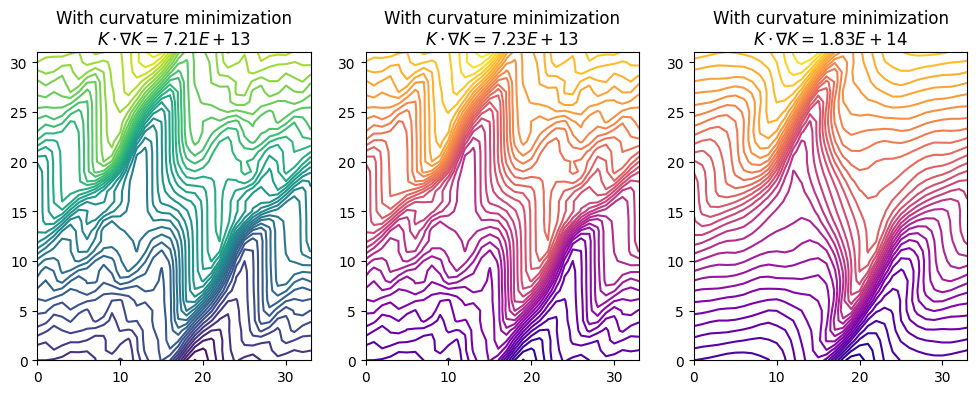

In [28]:
from decimal import Decimal
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title(
    'With curvature minimization\n'+r'$K\cdot\nabla K = ' 
    + str('%.2E' % Decimal(float(f_max_K_dot_grad_K_cyl_new))) 
    +'$'
)
plt.contour(Phi_with_net_current(qp, dofs), levels=40)
plt.subplot(1,3,2)
plt.title(
    'With curvature minimization\n'+r'$K\cdot\nabla K = ' 
    + str('%.2E' % Decimal(float(f_max_K_dot_grad_K_cyl_new2))) 
    +'$'
)
plt.contour(Phi_with_net_current(qp, dofs2), levels=40, cmap='plasma')
plt.subplot(1,3,3)
plt.title(
    'With curvature minimization\n'+r'$K\cdot\nabla K = ' 
    + str('%.2E' % Decimal(float(f_max_K_dot_grad_K_cyl_ref))) 
    +'$'
)
plt.contour(Phi_with_net_current(qp, regcoil_dofs), levels=40, cmap='plasma')
